In [99]:
# 1.目的
# 最終コーナーの通過順位を予想したものが着番の説明変数として有用なのか確認する（2025/9/22現在、有用ではない）

In [1]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# CSVファイルの読み込み
df = pd.read_csv('input_編集後_説明変数追加.csv', encoding='cp932')
print(f"dfの行数は {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
# フィルタ条件を適用
filtered_df = df[
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])
# NaN を除外（最低限のデータ整備）
# df = filtered_df.dropna(subset=['race_id', 'position_4', 'style_encoded', 'rank_diff'])
df = filtered_df
# 分母：全体の出現数（position_4, style_encodedの組み合わせ）
total_counts = (
    df
    .groupby(['y4_rank', 'style_encoded'])
    .size()
    .reset_index(name='total')
)
# 分子：flag_max_rank_diff_actual == 1 の馬だけ抽出
# df_max = df[df['flag_max_rank_diff_actual'] == 1]
# 分子：flag_max_last_3_furlongs == 1 の馬だけ抽出
df_max = df[df['flag_max_last_3_furlongs'] == 1]
# その組み合わせの出現数をカウント
match_counts = (
    df_max
    .groupby(['y4_rank', 'style_encoded']).size().reset_index(name='matched')
)
# マージして確率を計算
result = pd.merge(total_counts, match_counts, on=['y4_rank', 'style_encoded'], how='left')
result['matched'] = result['matched'].fillna(0)
result['probability'] = result['matched'] / result['total']
# 結果を表示
print(result.sort_values(by=['style_encoded', 'y4_rank']).head(32))
# 脚質ごとの total（出現回数）を集計
style_total_counts = (
    df
    .groupby('style_encoded').size().reset_index(name='total')
)
# 脚質ごとの matched（flag_max_rank_diff_actual == 1 の数）を集計
style_matched_counts = (
    # df[df['flag_max_rank_diff_actual'] == 1]
    df[df['flag_max_last_3_furlongs'] == 1]
    .groupby('style_encoded').size().reset_index(name='matched')
)
# 両者をマージ
style_result = pd.merge(style_total_counts, style_matched_counts, on='style_encoded', how='left')
# NaN（matchedが存在しない脚質）を0に補完
style_result['matched'] = style_result['matched'].fillna(0)
# 確率計算
style_result['probability'] = style_result['matched'] / style_result['total']
# style_encoded に対応する日本語ラベルを追加（任意）
style_map = {
    1: '逃げ',
    2: '先行',
    3: '差し',
    4: '追込'
}
style_result['style_label'] = style_result['style_encoded'].map(style_map)
# 結果を表示（style_encoded順に並び替え）
print(style_result[['style_encoded', 'style_label', 'matched', 'total', 'probability']].sort_values('style_encoded'))
# y4_rank ごとの total（出現回数）を集計
rank_total_counts = (
    df
    .groupby('y4_rank').size().reset_index(name='total')
)
# y4_rank ごとの matched（flag_max_rank_diff_actual == 1 の数）を集計
rank_matched_counts = (
    # df[df['flag_max_rank_diff_actual'] == 1]
    df[df['flag_max_last_3_furlongs'] == 1]
    .groupby('y4_rank').size().reset_index(name='matched')
)
# 両者をマージ
rank_result = pd.merge(rank_total_counts, rank_matched_counts, on='y4_rank', how='left')
# NaN（matchedが存在しないランク）を0に補完
rank_result['matched'] = rank_result['matched'].fillna(0)
# 確率を計算
rank_result['probability'] = rank_result['matched'] / rank_result['total']
# 表示（y4_rank順に並べる）
print(rank_result[['y4_rank', 'matched', 'total', 'probability']].sort_values('y4_rank'))

print(f"Matched 合計: {result['matched'].sum()}")
print(f"Total 合計: {result['total'].sum()}")
# y4_rank ごとの確率マップを作成
y4_rank_prob_map = rank_result.set_index('y4_rank')['probability'].to_dict()
# filtered_df に y4_rank_prob を追加
filtered_df['y4_rank_prob'] = filtered_df['y4_rank'].map(y4_rank_prob_map)
# style_encoded ごとの確率マップを作成
style_prob_map = style_result.set_index('style_encoded')['probability'].to_dict()
# filtered_df に style_encoded_prob を追加
filtered_df['style_encoded_prob'] = filtered_df['style_encoded'].map(style_prob_map)
# prob_mapは既に作成済み（position_4, style_encoded をキーにした辞書）
prob_map = result.set_index(['y4_rank', 'style_encoded'])['probability'].to_dict()
# 学習データと検証データの判定条件（例としてrace_dateで分割）
# ここは適宜調整してください
train_mask = filtered_df['race_date'].dt.year == 2023
test_mask = filtered_df['race_date'].dt.year == 2024
# 新カラム初期化
filtered_df['probability_of_max_rank_diff'] = np.nan
# 学習データには (position_4, style_encoded) をキーにprobability割り当て
filtered_df.loc[train_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[train_mask].apply(
    lambda row: prob_map.get((row['y4_rank'], row['style_encoded']), np.nan),
    axis=1
)
# 検証データには (y4_rank, style_encoded) をキーにprobability割り当て
filtered_df.loc[test_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[test_mask].apply(
    lambda row: prob_map.get((row['y4_rank'], row['style_encoded']), np.nan), axis=1)
# filtered_dfをCSVファイルとして出力
filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')

dfの行数は 2584 
filtered_dfの行数は 1728 
    y4_rank  style_encoded  total  matched  probability
0       1.0            1.0     78     12.0     0.153846
3       2.0            1.0     58      9.0     0.155172
6       3.0            1.0     35     11.0     0.314286
10      4.0            1.0     25      8.0     0.320000
14      5.0            1.0     11      3.0     0.272727
18      6.0            1.0      5      2.0     0.400000
1       1.0            2.0    132      8.0     0.060606
4       2.0            2.0    124     14.0     0.112903
7       3.0            2.0    107     19.0     0.177570
11      4.0            2.0     64      9.0     0.140625
15      5.0            2.0     37     13.0     0.351351
19      6.0            2.0     23      8.0     0.347826
22      7.0            2.0     11      4.0     0.363636
25      8.0            2.0      5      2.0     0.400000
2       1.0            3.0      6      0.0     0.000000
5       2.0            3.0     34      1.0     0.029412
8       3.0  

In [7]:
# ---------- 前提 ----------
# filtered_dfには race_id、horse_number、position_4、y4_rank_prob、style_encoded_prob、time_index、conditional_place_rate_10、jockey_place_rate_100 などが含まれている
# すでに filtered_df は 2023年と2024年のデータに絞られている前提

# ---------- モデル1: is_top4 ラベル付け ----------
def label_top4(group):
    group = group.sort_values('position_4')  # 小さい順が上位
    group['is_top4'] = [1 if i < 4 else 0 for i in range(len(group))]
    return group

df_m1 = filtered_df.copy()
df_m1 = df_m1.groupby('race_id').apply(label_top4).reset_index(drop=True)

# time_index_diff_from_avg 計算（モデル1用）
df_m1['time_index_diff_from_avg'] = df_m1.groupby('race_id')['time_index'].transform(lambda x: x - x.mean())

# モデル1用の特徴量と目的変数
features = ['y4_rank_prob', 'style_encoded_prob', 'time_index_diff_from_avg', 'conditional_place_rate_10', 'jockey_place_rate_100']
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

# ---------- モデル2: is_top2_in_top4 ラベル付け ----------
# まず、モデル1で上位4頭だった馬のみ対象
df_m2 = df_m1[df_m1['is_top4'] == 1].copy()

def label_top2(group):
    group = group.sort_values('position_4')
    group['is_top2_in_top4'] = [1 if i < 2 else 0 for i in range(len(group))]
    return group

df_m2 = df_m2.groupby('race_id').apply(label_top2).reset_index(drop=True)

# time_index_diff_from_avg（モデル2用）
df_m2['time_index_diff_from_avg'] = df_m2.groupby('race_id')['time_index'].transform(lambda x: x - x.mean())

# モデル2用の特徴量と目的変数
X_m2 = df_m2[features]
y_m2 = df_m2['is_top2_in_top4']

# ---------- モデル3: is_winner ラベル付け ----------
# モデル2で上位2頭だった馬のみ対象
df_m3 = df_m2[df_m2['is_top2_in_top4'] == 1].copy()

def label_winner(group):
    group = group.sort_values('position_4')
    group['is_winner'] = [1 if i == 0 else 0 for i in range(len(group))]
    return group

df_m3 = df_m3.groupby('race_id').apply(label_winner).reset_index(drop=True)
# time_index_diff_from_avg（モデル3用）
df_m3['time_index_diff_from_avg'] = df_m3.groupby('race_id')['time_index'].transform(lambda x: x - x.mean())

# モデル3用の特徴量と目的変数
X_m3 = df_m3[features]
y_m3 = df_m3['is_winner']


C:\Users\ryo\AppData\Local\Temp\ipykernel_9900\1253371353.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_m1 = df_m1.groupby('race_id').apply(label_top4).reset_index(drop=True)
C:\Users\ryo\AppData\Local\Temp\ipykernel_9900\1253371353.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_m2 = df_m2.groupby('race_id').apply(label_top2).reset_index(drop=True)
C:\Users\ryo\AppData\Local\Temp\ipykerne

In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ---------- モデル1の学習 ----------
X_train_m1, X_val_m1, y_train_m1, y_val_m1 = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)
model1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model1.fit(X_train_m1, y_train_m1)

# ---------- モデル2の学習 ----------
X_train_m2, X_val_m2, y_train_m2, y_val_m2 = train_test_split(X_m2, y_m2, test_size=0.2, random_state=42)
model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model2.fit(X_train_m2, y_train_m2)

# ---------- モデル3の学習 ----------
X_train_m3, X_val_m3, y_train_m3, y_val_m3 = train_test_split(X_m3, y_m3, test_size=0.2, random_state=42)
model3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model3.fit(X_train_m3, y_train_m3)

# ============================================================
# ✅ 推論フェーズ（レース単位で順にモデルを適用して1着を予測）
# ============================================================

# 対象とする検証データのみ（例：2024年）
df_test = filtered_df[filtered_df['race_date'].dt.year == 2024].copy()

# 結果格納リスト
full_predictions = []

for race_id, group in df_test.groupby('race_id'):
    # ---------- モデル1 ----------
    group_m1 = group.copy()
    group_m1['time_index_diff_from_avg'] = group_m1['time_index'] - group_m1['time_index'].mean()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]

    # 上位4頭を選出
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    group_m1.iloc[:4, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ---------- モデル2 ----------
    top4 = group_m1[group_m1['selected_in_m1'] == 1].copy()
    top4['time_index_diff_from_avg'] = top4['time_index'] - top4['time_index'].mean()
    X_test_m2 = top4[features]
    top4['pred_prob_m2'] = model2.predict_proba(X_test_m2)[:, 1]

    # 上位2頭を選出
    top4 = top4.sort_values('pred_prob_m2', ascending=False)
    top4['selected_in_m2'] = 0
    top4.iloc[:2, top4.columns.get_loc('selected_in_m2')] = 1

    # ---------- モデル3 ----------
    top2 = top4[top4['selected_in_m2'] == 1].copy()
    top2['time_index_diff_from_avg'] = top2['time_index'] - top2['time_index'].mean()
    X_test_m3 = top2[features]
    top2['pred_prob_m3'] = model3.predict_proba(X_test_m3)[:, 1]

    # 最終1着予測
    top2 = top2.sort_values('pred_prob_m3', ascending=False)
    top2['selected_in_m3'] = 0
    top2.iloc[0, top2.columns.get_loc('selected_in_m3')] = 1

    # ---------- 結果の統合 ----------
    group_m1 = group_m1.merge(
        top4[['horse_number', 'pred_prob_m2', 'selected_in_m2']],
        on='horse_number', how='left'
    )
    group_m1 = group_m1.merge(
        top2[['horse_number', 'pred_prob_m3', 'selected_in_m3']],
        on='horse_number', how='left'
    )

    # NaN補完（未選出馬には0を入れる）
    for col in ['pred_prob_m2', 'selected_in_m2', 'pred_prob_m3', 'selected_in_m3']:
        group_m1[col] = group_m1[col].fillna(0)

    # ✅ finish_rank も含めて出力
    result_cols = [
        'race_id', 'horse_number', 'finish_rank',
        'pred_prob_m1', 'selected_in_m1',
        'pred_prob_m2', 'selected_in_m2',
        'pred_prob_m3', 'selected_in_m3'
    ]
    full_predictions.append(group_m1[result_cols])

# 全レース結合
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank を含めた全段階の予測結果CSVを出力しました。")

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:37:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:37:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:37:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank を含めた全段階の予測結果CSVを出力しました。


In [21]:
### モデルの評価 ###

# モデル1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= 4).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# モデル2
m2_preds = full_pred_df[full_pred_df['selected_in_m2'] == 1]
m2_total = len(m2_preds)
m2_hits = (m2_preds['finish_rank'] <= 2).sum()
m2_accuracy = m2_hits / m2_total if m2_total > 0 else 0

# モデル3
m3_preds = full_pred_df[full_pred_df['selected_in_m3'] == 1]
m3_total = len(m3_preds)
m3_hits = (m3_preds['finish_rank'] == 1).sum()
m3_accuracy = m3_hits / m3_total if m3_total > 0 else 0

# 出力
print("▼ モデル1（上位4頭予測）の的中率")
print(f"  予測数: {m1_total}, 的中数: {m1_hits}, 的中率: {m1_accuracy:.4f}（{m1_accuracy:.2%}）\n")

print("▼ モデル2（上位2頭予測）の的中率")
print(f"  予測数: {m2_total}, 的中数: {m2_hits}, 的中率: {m2_accuracy:.4f}（{m2_accuracy:.2%}）\n")

print("▼ モデル3（1着予測）の的中率")
print(f"  予測数: {m3_total}, 的中数: {m3_hits}, 的中率: {m3_accuracy:.4f}（{m3_accuracy:.2%}）")

# モデル3で「1着」と予測したレコード（selected_in_m3 == 1）
final_predictions = full_pred_df[full_pred_df['selected_in_m3'] == 1]

# 分母：予測数
total_predicted = len(final_predictions)

# 分子：実際に的中（finish_rank == 1）した数
total_hits = (final_predictions['finish_rank'] == 1).sum()

# 的中率の計算（ゼロ除算対策あり）
if total_predicted > 0:
    accuracy = total_hits / total_predicted
else:
    accuracy = 0.0

# 結果の表示
print(f"モデル3の予測数（selected_in_m3 == 1）: {total_predicted}")
print(f"そのうち的中（finish_rank == 1）の数: {total_hits}")
print(f"的中率: {accuracy:.4f}（{accuracy:.2%}）")

▼ モデル1（上位4頭予測）の的中率
  予測数: 452, 的中数: 350, 的中率: 0.7743（77.43%）

▼ モデル2（上位2頭予測）の的中率
  予測数: 226, 的中数: 146, 的中率: 0.6460（64.60%）

▼ モデル3（1着予測）の的中率
  予測数: 113, 的中数: 62, 的中率: 0.5487（54.87%）
モデル3の予測数（selected_in_m3 == 1）: 113
そのうち的中（finish_rank == 1）の数: 62
的中率: 0.5487（54.87%）


In [25]:
# モデルの学習
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=1,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# y*_predの評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
# y*_rankの評価
# 予測結果を DataFrame に変換して race_id と紐付け
y_pred_df = pd.DataFrame({
    'race_id': filtered_df.loc[x_test.index, 'race_id'].values,
    'y_pred': y_pred
})
# 各レースごとに予測値の小さい順に順位を振る（昇順）
y_pred_df['y_rank'] = y_pred_df.groupby('race_id')['y_pred'].rank(method='first').astype(int)
# 3. 実着順を追加
y_pred_df['y_actual'] = y_test.values
# 正解率（的中率）の計算と出力
correct_top1_count = ((y_pred_df['y_rank'] == 1) & (y_pred_df['y_actual'] == 1)).sum()
unique_race_count = y_pred_df['race_id'].nunique()
top1_accuracy = correct_top1_count / unique_race_count
print(f"1着予測的中率: {top1_accuracy:.4f} （{correct_top1_count} / {unique_race_count}）")
# 実データを出力して確認
y_pred_df.sort_values(by=['race_id', 'y_actual'], ascending=[True, True]).head(56)

NameError: name 'x_train' is not defined

In [99]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 前提 ---
# filtered_df : 元のDataFrame（race_id, finish_rank, 特徴量などを含む）
# ここではすでに filtered_df が読み込まれている前提

# --- 特徴量リスト ---
features = [
    'probability_of_max_rank_diff',
    'time_index_diff_from_avg',
    'conditional_place_rate_10',
    'jockey_place_rate_100'
]

# --- ① 除外処理 ---
x_with_race = filtered_df[features + ['race_id']].copy()

nan_counts_per_race = x_with_race.groupby('race_id')[features].apply(lambda g: g.isna().sum())
race_ids_to_exclude = nan_counts_per_race[(nan_counts_per_race >= 5).any(axis=1)].index
filtered_df = filtered_df[~filtered_df['race_id'].isin(race_ids_to_exclude)].reset_index(drop=True)

# --- ② NaN補完処理 ---
x = filtered_df[features + ['race_id']].copy()

def fill_na_with_group_mean(group, feature):
    na_count = group[feature].isna().sum()
    if na_count <= 4:
        mean_val = group[feature].mean()
        group[feature] = group[feature].fillna(mean_val)
    return group

for feature in features:
    x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feature))

# race_idは説明変数には使わない
x = x.drop(columns=['race_id'])
filtered_df[features] = x

# --- ③ 目的変数作成 ---
filtered_df['y_model1'] = (filtered_df['finish_rank'] <= 4).astype(int)
filtered_df['y_model2'] = (filtered_df['finish_rank'] <= 2).astype(int)
filtered_df['y_model3'] = (filtered_df['finish_rank'] == 1).astype(int)

# --- ④ 学習/検証データ分割 ---
# レースIDの先頭2桁から割合を計算（例）
filtered_df['race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
count_23 = (filtered_df['race_id_year'] == '23').sum()
count_24 = (filtered_df['race_id_year'] == '24').sum()
rate_23 = round(count_23 / (count_23 + count_24), 10) + 0.001

# インデックスを分割（時系列考慮のためshuffle=False）
train_idx, test_idx = train_test_split(filtered_df.index, train_size=rate_23, shuffle=False)

x_train = x.loc[train_idx]
x_test = x.loc[test_idx]

y_train = filtered_df.loc[train_idx, ['y_model1', 'y_model2', 'y_model3']]
y_test = filtered_df.loc[test_idx, ['y_model1', 'y_model2', 'y_model3']]

# --- ⑤ モデル1: 上位4頭 vs 下位4頭（二値分類） ---

model1 = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=1,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model1.fit(x_train, y_train['y_model1'])

# 予測確率（上位4頭になる確率）
y_pred_proba1 = model1.predict_proba(x_test)[:, 1]
filtered_df.loc[test_idx, 'model1_proba'] = y_pred_proba1

# レースごとに上位4頭を model1_pred = 1 に割り当て
def assign_top4(group):
    group = group.copy()
    top4_idx = group.nlargest(4, 'model1_proba').index
    group['model1_pred'] = 0
    group.loc[top4_idx, 'model1_pred'] = 1
    return group

filtered_df.loc[test_idx] = (
    filtered_df.loc[test_idx]
    .groupby('race_id', group_keys=False)
    .apply(assign_top4)
)

# 精度評価（モデル1）
y_test1 = filtered_df.loc[test_idx, 'y_model1']
y_pred1 = filtered_df.loc[test_idx, 'model1_pred']
acc1 = accuracy_score(y_test1, y_pred1)
print(f"モデル1 Accuracy（上位4頭）: {acc1:.4f}")

# --- ⑥ モデル2: 上位4頭の中で上位2頭 vs 下位2頭 ---

# 学習データ：train_idxかつ finish_rank <= 4 のみ
train_mask2 = train_idx.intersection(filtered_df[filtered_df['finish_rank'] <= 4].index)
x_train2 = x.loc[train_mask2]
y_train2 = filtered_df.loc[train_mask2, 'y_model2']

# テストデータ：model1_pred == 1 かつ test_idx内のみ
test_mask2 = filtered_df.loc[test_idx].query('model1_pred == 1').index
x_test2 = x.loc[test_mask2]
y_test2 = filtered_df.loc[test_mask2, 'y_model2']

model2 = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=1,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model2.fit(x_train2, y_train2)

y_pred_proba2 = model2.predict_proba(x_test2)[:, 1]
filtered_df.loc[test_mask2, 'model2_proba'] = y_pred_proba2

# レースごとに上位2頭を model2_pred = 1 に割り当て
def assign_top2(group):
    group = group.copy()
    top2_idx = group.nlargest(2, 'model2_proba').index
    group['model2_pred'] = 0
    group.loc[top2_idx, 'model2_pred'] = 1
    return group

filtered_df.loc[test_mask2] = (
    filtered_df.loc[test_mask2]
    .groupby('race_id', group_keys=False)
    .apply(assign_top2)
)

# 精度評価（モデル2）
y_test2_eval = filtered_df.loc[test_mask2, 'y_model2']
y_pred2 = filtered_df.loc[test_mask2, 'model2_pred']
acc2 = accuracy_score(y_test2_eval, y_pred2)
print(f"モデル2 Accuracy（上位2頭判定）: {acc2:.4f}")

# --- ⑦ モデル3: 上位2頭の中で1着 vs 2着 ---

# 学習データ：train_idxかつ finish_rank <= 2 のみ
train_mask3 = train_idx.intersection(filtered_df[filtered_df['finish_rank'] <= 2].index)
x_train3 = x.loc[train_mask3]
y_train3 = filtered_df.loc[train_mask3, 'y_model3']

# テストデータ：model2_pred == 1 かつ test_idx内のみ
test_mask3 = filtered_df.loc[test_idx].query('model2_pred == 1').index
x_test3 = x.loc[test_mask3]
y_test3 = filtered_df.loc[test_mask3, 'y_model3']

model3 = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=1,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model3.fit(x_train3, y_train3)

y_pred_proba3 = model3.predict_proba(x_test3)[:, 1]
filtered_df.loc[test_mask3, 'model3_proba'] = y_pred_proba3

# レースごとに1頭だけ model3_pred = 1 に割り当て
def assign_top1(group):
    group = group.copy()
    top1_idx = group.nlargest(1, 'model3_proba').index
    group['model3_pred'] = 0
    group.loc[top1_idx, 'model3_pred'] = 1
    return group

filtered_df.loc[test_mask3] = (
    filtered_df.loc[test_mask3]
    .groupby('race_id', group_keys=False)
    .apply(assign_top1)
)

# 精度評価（モデル3）
y_test3_eval = filtered_df.loc[test_mask3, 'y_model3']
y_pred3 = filtered_df.loc[test_mask3, 'model3_pred']
acc3 = accuracy_score(y_test3_eval, y_pred3)
print(f"モデル3 Accuracy（1着判定）: {acc3:.4f}")


C:\Users\ryo\AppData\Local\Temp\ipykernel_17976\3397737942.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feature))
C:\Users\ryo\AppData\Local\Temp\ipykernel_17976\3397737942.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feat

モデル1 Accuracy（上位4頭）: 0.6622


C:\Users\ryo\AppData\Local\Temp\ipykernel_17976\3397737942.py:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_top2)


モデル2 Accuracy（上位2頭判定）: 0.6150
モデル3 Accuracy（1着判定）: 0.5678


C:\Users\ryo\AppData\Local\Temp\ipykernel_17976\3397737942.py:184: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_top1)


In [101]:
# モデル3で1着と予測した馬が実際に1着だった数
final_correct_preds = (
    filtered_df.loc[model3_mask]
    .query('model3_pred == 1 and finish_rank == 1')
)
final_accuracy = len(final_correct_preds)
total_target_races = filtered_df.loc[model3_mask, 'race_id'].nunique()
print(f"最終1着的中数: {final_accuracy}")
print(f"対象レース数（モデル3まで残ったレース）: {total_target_races}")
print(f"最終1着的中率: {final_accuracy / total_target_races:.4f}")

最終1着的中数: 51
対象レース数（モデル3まで残ったレース）: 113
最終1着的中率: 0.4513


In [103]:
# モデル1の予測結果を「上位4頭」「下位4頭」で表すカラムを追加
filtered_df['model1_pred_label'] = filtered_df['model1_pred'].map({1: '1234', 0: '5678'})
# モデル2の予測結果（上位2頭・下位2頭）のカラムを追加
# model2_predがNaN（予測していない行）は空文字にするなど調整
filtered_df['model2_pred_label'] = filtered_df['model2_pred'].map({1: '12', 0: '34'})
# filtered_df['model2_pred_label'] = filtered_df['model2_pred_label'].fillna('')
# モデル3の予測結果（1着か2着か）のカラムを追加
filtered_df['model3_pred_label'] = filtered_df['model3_pred'].map({1: '1', 0: '2'})
# filtered_df['model3_pred_label'] = filtered_df['model3_pred_label'].fillna('')
# 予測結果を含めたデータフレームをCSVファイルに保存（例: result_predictions.csv）
filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\result_predictions.csv', index=False, encoding='cp932')
print("予測結果をresult_predictions.csvに出力しました。")

予測結果をresult_predictions.csvに出力しました。


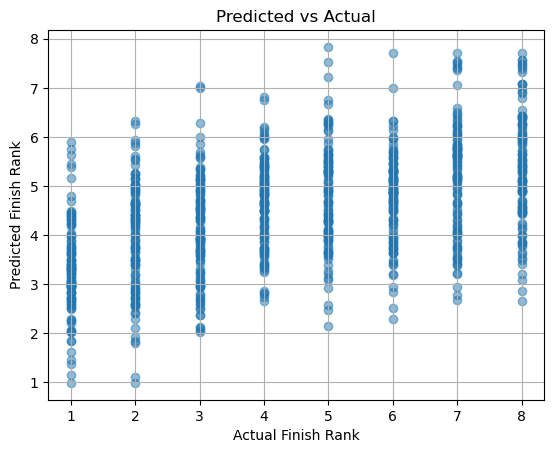

各特徴量の重要度（大きいほど重要）:
                        Feature  Importance
1      time_index_diff_from_avg    0.444348
3         jockey_place_rate_100    0.208266
0  probability_of_max_rank_diff    0.185595
2     conditional_place_rate_10    0.161791


C:\Users\ryo\AppData\Local\Temp\ipykernel_17976\1579747339.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


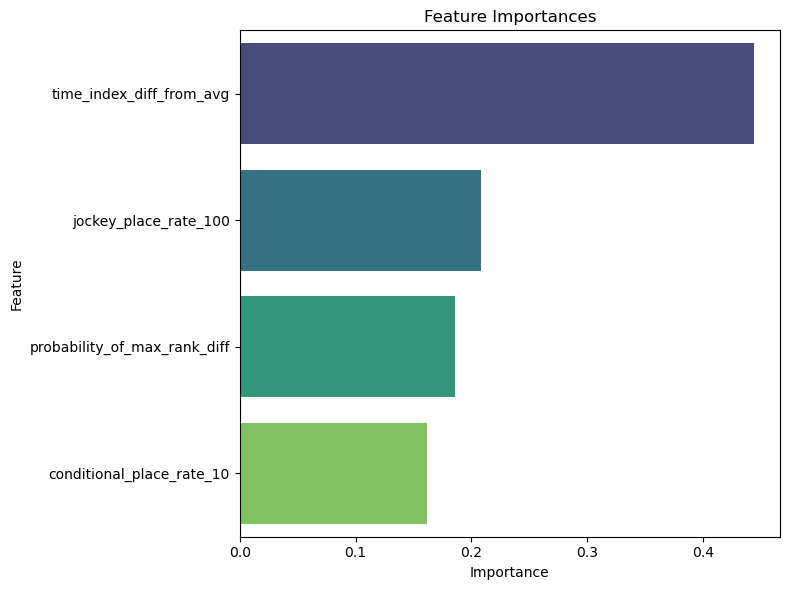

In [91]:
# 予想と正解のプロット
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Finish Rank")
plt.ylabel("Predicted Finish Rank")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()
# 特徴量の重要度
importances = model.feature_importances_
feature_names = x.columns
# DataFrameにしてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("各特徴量の重要度（大きいほど重要）:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# メモ
# 説明変数にprobability_of_max_rank_diffを含めるとR2が下がるため、
# probability_of_max_rank_diffの重要度が2番目に高くなっているのはおかしい

In [15]:
# filtered_dfをCSVファイルとして出力
filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')